## Librerias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nba_api.stats.endpoints import commonplayerinfo, playercareerstats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [129]:
data = pd.read_csv('features_df.csv')

## Importar datos

In [2]:
jugadores_df = pd.read_csv('csv/player.csv')
info_df = pd.read_csv('csv/common_player_info.csv')
info_df = info_df[['person_id', 'position', 'height', 'weight', 'birthdate', 'from_year', 'to_year']]
jugadores_df = jugadores_df[['id', 'is_active']].merge(info_df, left_on='id', right_on='person_id', how='left')
jugadores_df = jugadores_df.loc[jugadores_df['is_active'] == 1]

In [3]:
games = pd.read_csv('csv\game.csv')
df = pd.read_csv('other csv\play_by_play.csv')

<>:1: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\p'
C:\Users\pedro\AppData\Local\Temp\ipykernel_27340\716882387.py:1: SyntaxWarning: invalid escape sequence '\g'
  games = pd.read_csv('csv\game.csv')
C:\Users\pedro\AppData\Local\Temp\ipykernel_27340\716882387.py:2: SyntaxWarning: invalid escape sequence '\p'
  df = pd.read_csv('other csv\play_by_play.csv')


In [4]:
games['game_date'] = pd.to_datetime(games['game_date'])
games['year'] = games['game_date'].dt.year
games = games.loc[(games['year']>= 2014) & ((games['season_type']=='Regular Season') | (games['season_type']=='Playoffs'))]

In [5]:
game_ids_filtrados = games['game_id'].unique()
df = df[df['game_id'].isin(game_ids_filtrados)]

## Funciones extraer variables numericas 


- # Info general

In [7]:
def countGames(player_id):
    df_player = df.loc[(df['player1_id'] == player_id) | (df['player2_id'] == player_id) | (df['player3_id'] == player_id)]
    return len(df_player.drop_duplicates(subset='game_id'))

jugadores_df['games_played'] = jugadores_df['id'].apply(countGames)

In [8]:
def getAssists(player_id):
    df_player = df.loc[(df['player2_id'] == player_id) & (df['eventmsgtype'] == 1)]
    df_values = df_player.groupby(by='game_id').size().reset_index(name='values')
    games_played = jugadores_df.loc[jugadores_df['id'] == player_id]['games_played']
    if not games_played.empty:
        games_played = games_played.iloc[0]
        if pd.isna(games_played) or games_played == 0:
            return 0 
    else:
        return 0
    return df_values['values'].sum() / games_played
jugadores_df['assists'] = jugadores_df['id'].apply(getAssists)

In [9]:
def getDoubles(player_id):
    df_player = df.loc[(df['eventmsgtype']==1) & (df['player1_id']==player_id) & ~((df['eventmsgactiontype']==1) | (df['eventmsgactiontype']==103))]
    df_values = df_player.groupby(by='game_id').size().reset_index(name='values')
    games_played = jugadores_df.loc[jugadores_df['id'] == player_id]['games_played']
    if not games_played.empty:
        games_played = games_played.iloc[0]
        if pd.isna(games_played) or games_played == 0:
            return 0 
    else:
        return 0
    return df_values['values'].sum() / games_played
jugadores_df['doubles'] = jugadores_df['id'].apply(getDoubles)


In [10]:
def getTriples(player_id):
    df_player = df.loc[(df['eventmsgtype']==1) & (df['player1_id']==player_id) & ((df['eventmsgactiontype']==1) | (df['eventmsgactiontype']==103))]
    df_values = df_player.groupby(by='game_id').size().reset_index(name='values')
    games_played = jugadores_df.loc[jugadores_df['id'] == player_id]['games_played']
    if not games_played.empty:
        games_played = games_played.iloc[0]
        if pd.isna(games_played) or games_played == 0:
            return 0 
    else:
        return 0
    return df_values['values'].sum() / games_played

jugadores_df['triples'] = jugadores_df['id'].apply(getTriples)

In [11]:
def getRebounds(player_id):
    df_player = df.loc[(df['eventmsgtype'] == 4) & (df['player1_id'] == player_id)]
    df_values = df_player.groupby(by='game_id').size().reset_index(name='values')
    games_played = jugadores_df.loc[jugadores_df['id'] == player_id]['games_played']
    if not games_played.empty:
        games_played = games_played.iloc[0]
        if pd.isna(games_played) or games_played == 0:
            return 0 
    else:
        return 0
    return df_values['values'].sum() / games_played
jugadores_df['rebounds'] = jugadores_df['id'].apply(getRebounds)

- # Tiros libres

In [12]:
def getFTPerGame(player_id):
    df_player = df.loc[(df['eventmsgtype']==3) & (df['player1_id']==player_id) & ((df['eventmsgactiontype'].isin([10,12,13,14,15,16,19,20,21,22,25,26,28,29])))]
    df_values = df_player.groupby(by='game_id').size().reset_index(name='values')
    games_played = jugadores_df.loc[jugadores_df['id'] == player_id]['games_played']
    if not games_played.empty:
        games_played = games_played.iloc[0]
        if pd.isna(games_played) or games_played == 0:
            return 0 
    else:
        return 0
    return df_values['values'].sum() / games_played

jugadores_df['FT_per_game'] = jugadores_df['id'].apply(getFTPerGame)

In [13]:
def getSuccessfulFreeThrow(player_id):
    df_player = df.loc[(df['eventmsgtype']==3) & (df['player1_id']==player_id) & ((df['eventmsgactiontype'].isin([10,12,13,14,15,16,19,20,21,22,25,26,28,29])))]
    df_values = df_player.groupby(by='game_id').size().reset_index(name='values')
    return df_values['values'].sum()


jugadores_df['successful_FT'] = jugadores_df['id'].apply(getSuccessfulFreeThrow)

In [14]:
def getTotalFreeThrows(player_id):
    df_player = df.loc[(df['eventmsgtype']==3) & (df['player1_id']==player_id)]
    df_values = df_player.groupby(by='game_id').size().reset_index(name='values')
    return df_values['values'].sum()


jugadores_df['total_free_throws'] = jugadores_df['id'].apply(getTotalFreeThrows)

In [15]:
def getFTPercentage(player_id):
    successful = jugadores_df.loc[jugadores_df['id']==player_id]['successful_FT'].iloc[0]
    total = jugadores_df.loc[jugadores_df['id']==player_id]['total_free_throws'].iloc[0]
    if total == 0:
        return 0
    
    return successful/total

jugadores_df['FT_percentage'] = jugadores_df['id'].apply(getFTPercentage)

- # Robos

In [16]:
def getSteals(player_id):
    df_player = df.loc[(df['eventmsgtype']==5) & (df['player2_id']==player_id) & ((df['eventmsgactiontype'].isin([0,1,2,41])))]
    df_values = df_player.groupby(by='game_id').size().reset_index(name='values')
    games_played = jugadores_df.loc[jugadores_df['id'] == player_id]['games_played']
    if not games_played.empty:
        games_played = games_played.iloc[0]
        if pd.isna(games_played) or games_played == 0:
            return 0 
    else:
        return 0
    return df_values['values'].sum() / games_played

jugadores_df['steals'] = jugadores_df['id'].apply(getSteals)

In [17]:
def getStolen(player_id):
    df_player = df.loc[(df['eventmsgtype']==5) & (df['player1_id']==player_id) & ((df['eventmsgactiontype'].isin([0,1,2,41])))]
    df_values = df_player.groupby(by='game_id').size().reset_index(name='values')
    games_played = jugadores_df.loc[jugadores_df['id'] == player_id]['games_played']
    if not games_played.empty:
        games_played = games_played.iloc[0]
        if pd.isna(games_played) or games_played == 0:
            return 0 
    else:
        return 0
    return df_values['values'].sum() / games_played

jugadores_df['lost_balls'] = jugadores_df['id'].apply(getStolen)

- # Faltas

In [18]:
def getFouls(player_id):
    df_player = df.loc[(df['eventmsgtype'] == 6)& (df['player1_id'] == player_id)]
    df_values = df_player.groupby(by='game_id').size().reset_index(name='values')
    games_played = jugadores_df.loc[jugadores_df['id'] == player_id]['games_played']
    if not games_played.empty:
        games_played = games_played.iloc[0]
        if pd.isna(games_played) or games_played == 0:
            return 0 
    else:
        return 0
    return df_values['values'].sum() / games_played



jugadores_df['fouls']= jugadores_df['id'].apply(getFouls)

In [19]:
def getDribblingFouls(player_id):
    df_player = df.loc[(df['eventmsgtype']==5) & (df['player1_id']==player_id) & ((df['eventmsgactiontype']).isin([6,7]))]
    df_values = df_player.groupby(by='game_id').size().reset_index(name='values')
    games_played = jugadores_df.loc[jugadores_df['id'] == player_id]['games_played']
    if not games_played.empty:
        games_played = games_played.iloc[0]
        if pd.isna(games_played) or games_played == 0:
            return 0 
    else:
        return 0
    return df_values['values'].sum() / games_played

jugadores_df['dribbling_fouls'] = jugadores_df['id'].apply(getDribblingFouls)

In [20]:
def getTravels(player_id):
    df_player = df.loc[(df['eventmsgtype']==5) & (df['player1_id']==player_id) & ((df['eventmsgactiontype'])==4)]
    df_values = df_player.groupby(by='game_id').size().reset_index(name='values')
    games_played = jugadores_df.loc[jugadores_df['id'] == player_id]['games_played']
    if not games_played.empty:
        games_played = games_played.iloc[0]
        if pd.isna(games_played) or games_played == 0:
            return 0 
    else:
        return 0
    return df_values['values'].sum() / games_played

jugadores_df['travels'] = jugadores_df['id'].apply(getTravels)

In [21]:
def getBlockFouls(player_id):
    df_player = df.loc[(df['eventmsgtype']==6) & (df['player1_id']==player_id) & ((df['eventmsgactiontype']).isin([2,27,29]))]
    df_values = df_player.groupby(by='game_id').size().reset_index(name='values')
    games_played = jugadores_df.loc[jugadores_df['id'] == player_id]['games_played']
    if not games_played.empty:
        games_played = games_played.iloc[0]
        if pd.isna(games_played) or games_played == 0:
            return 0 
    else:
        return 0
    return df_values['values'].sum() / games_played

jugadores_df['block_fouls'] = jugadores_df['id'].apply(getBlockFouls)

In [22]:
def getBlockFouls2(player_id):
    df_player = df.loc[(df['eventmsgtype']==6) & (df['player2_id']==player_id) & ((df['eventmsgactiontype']).isin([2,27,29]))]
    df_values = df_player.groupby(by='game_id').size().reset_index(name='values')
    games_played = jugadores_df.loc[jugadores_df['id'] == player_id]['games_played']
    if not games_played.empty:
        games_played = games_played.iloc[0]
        if pd.isna(games_played) or games_played == 0:
            return 0 
    else:
        return 0
    return df_values['values'].sum() / games_played

jugadores_df['block_fouls_recibidas'] = jugadores_df['id'].apply(getBlockFouls2)

In [23]:
def getOffensiveFouls(player_id):
    df_player = df.loc[(df['eventmsgtype']==6) & (df['player1_id']==player_id) & ((df['eventmsgactiontype']).isin([4]))]
    df_values = df_player.groupby(by='game_id').size().reset_index(name='values')
    games_played = jugadores_df.loc[jugadores_df['id'] == player_id]['games_played']
    if not games_played.empty:
        games_played = games_played.iloc[0]
        if pd.isna(games_played) or games_played == 0:
            return 0 
    else:
        return 0
    return df_values['values'].sum() / games_played

jugadores_df['offensive_fouls'] = jugadores_df['id'].apply(getOffensiveFouls)

In [24]:
def getOffensiveFouls2(player_id):
    df_player = df.loc[(df['eventmsgtype']==6) & (df['player2_id']==player_id) & ((df['eventmsgactiontype']).isin([4]))]
    df_values = df_player.groupby(by='game_id').size().reset_index(name='values')
    games_played = jugadores_df.loc[jugadores_df['id'] == player_id]['games_played']
    if not games_played.empty:
        games_played = games_played.iloc[0]
        if pd.isna(games_played) or games_played == 0:
            return 0 
    else:
        return 0
    return df_values['values'].sum() / games_played

jugadores_df['offensive_fouls_recibidas'] = jugadores_df['id'].apply(getOffensiveFouls2)

In [25]:
def getReboundFouls(player_id):
    df_player = df.loc[(df['eventmsgtype']==6) & (df['player1_id']==player_id) & ((df['eventmsgactiontype']).isin([3]))]
    df_values = df_player.groupby(by='game_id').size().reset_index(name='values')
    games_played = jugadores_df.loc[jugadores_df['id'] == player_id]['games_played']
    if not games_played.empty:
        games_played = games_played.iloc[0]
        if pd.isna(games_played) or games_played == 0:
            return 0 
    else:
        return 0
    return df_values['values'].sum() / games_played

jugadores_df['rebound_fouls'] = jugadores_df['id'].apply(getReboundFouls)

In [26]:
def getReboundFouls2(player_id):
    df_player = df.loc[(df['eventmsgtype']==6) & (df['player2_id']==player_id) & ((df['eventmsgactiontype']).isin([3]))]
    df_values = df_player.groupby(by='game_id').size().reset_index(name='values')
    games_played = jugadores_df.loc[jugadores_df['id'] == player_id]['games_played']
    if not games_played.empty:
        games_played = games_played.iloc[0]
        if pd.isna(games_played) or games_played == 0:
            return 0 
    else:
        return 0
    return df_values['values'].sum() / games_played

jugadores_df['rebound_fouls_recibidas'] = jugadores_df['id'].apply(getReboundFouls2)

In [27]:
jugadores_df = jugadores_df.drop(columns=['is_active', 'person_id', 'birthdate', 'from_year', 'to_year', 'total_free_throws', 'successful_FT'])

In [28]:
def jugadoresDFFilter(jugadores_df, action:str):
    if action == 'filtrar':
        return jugadores_df.loc[(jugadores_df['position']=='Forward')|(jugadores_df['position']=='Center')|(jugadores_df['position']=='Guard')]


In [29]:
jugadores_df_filtered = jugadoresDFFilter(jugadores_df=jugadores_df, action='filtrar')

In [30]:
df_final = jugadores_df_filtered

## Funciones viejas 

In [59]:
def createRow(df, player_id, jugadores_df):
    
    player_info = jugadores_df.loc[jugadores_df['id'] == player_id]
    
    
   
    
    rebounds = getRebounds(df, player_id)
    assists = getAssists(df, player_id)
    triples = getTriples(df, player_id)
    doubles = getDoubles(df, player_id)

    avg_rebounds = sum(rebounds['values']) / len(rebounds['values']) if len(rebounds['values']) > 0 else 0
    avg_assists = sum(assists['values']) / len(assists['values']) if len(assists['values']) > 0 else 0
    avg_triples = sum(triples['values']) / len(triples['values']) if len(triples['values']) > 0 else 0
    avg_dobles = sum(doubles['values']) / len(doubles['values']) if len(doubles['values']) > 0 else 0
    
#    player_name = player_info['id'].values[0]
#    player_position = player_info['position'].values[0]
#    player_height = player_info['height'].values[0]
#    player_weight = player_info['weight'].values[0]
#     player_age = today.year - birthdate.year - ((today.month, today.day) < (birthdate.month, birthdate.day))
#    career_time = player_info['to_year'].values[0] - player_info['from_year'].values[0]

    new_row = {
        'id': player_id,
        'avg_assists': avg_assists,
        'avg_dobles': avg_dobles,
        'avg_triples': avg_triples,
        'avg_rebounds': avg_rebounds,
    }

    new_rows_df = pd.DataFrame([new_row])

    return new_rows_df

In [12]:

all_players = jugadores_df['id'].to_list()
df_stats = pd.DataFrame()
for i in all_players:
    result = createRow(df, i, jugadores_df)
    df_stats= pd.concat([df_stats, result], ignore_index=True)


In [13]:
df_final = df_stats.merge(jugadores_df, on=['id', 'id']).drop(columns=['person_id', 'from_year', 'to_year', 'is_active'])
age = pd.DataFrame(getAge(df_final))
df_final = df_final.drop(columns=['birthdate'])


## Correlograma

In [50]:
import re
import pandas as pd

# Función para convertir height en formato '6-8' a pulgadas totales
def height_to_inches(height):
    if pd.isna(height):  # Check for NaN values
        return None
    if isinstance(height, str):  # Ensure height is a string
        match = re.match(r"(\d+)-(\d+)", height)
        if match:
            feet, inches = match.groups()
            return int(feet) * 12 + int(inches)
    return None  # Return None if height is not a valid format

# Suponiendo que df_final ya está definido, aplicar la conversión a la columna 'height'
df_final['height_inches'] = df_final['height'].apply(height_to_inches)

C:\Users\pedro\AppData\Local\Temp\ipykernel_27340\2921402084.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['height_inches'] = df_final['height'].apply(height_to_inches)


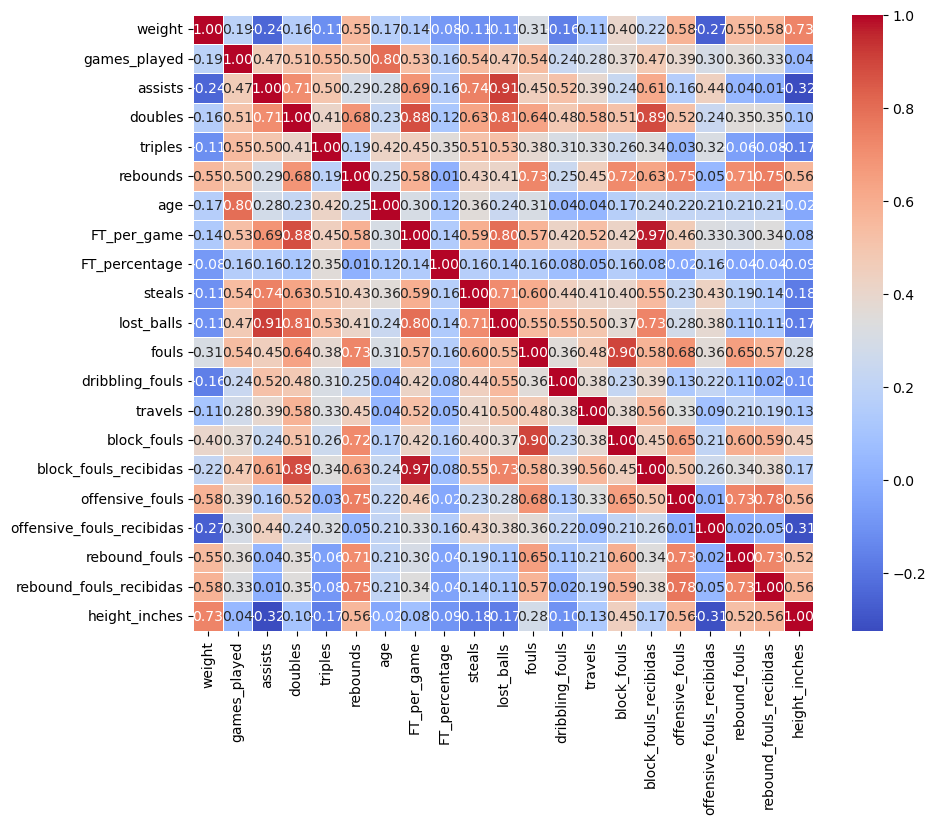

In [74]:
df_final = df_final.dropna()
df_final = df_final[
    (df_final['triples'] != 0) &
    (df_final['doubles'] != 0) &
    (df_final['assists'] != 0)
]

numeric_columns = df_final.select_dtypes(include=['float64', 'int64']).columns.drop(['id'])

correlation_matrix = df_final[numeric_columns].corr()

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

plt.show()

# Exportar DF filtrado

In [56]:
df_final.to_csv('features_df.csv', index=False)

# Entrenamiento Modelo

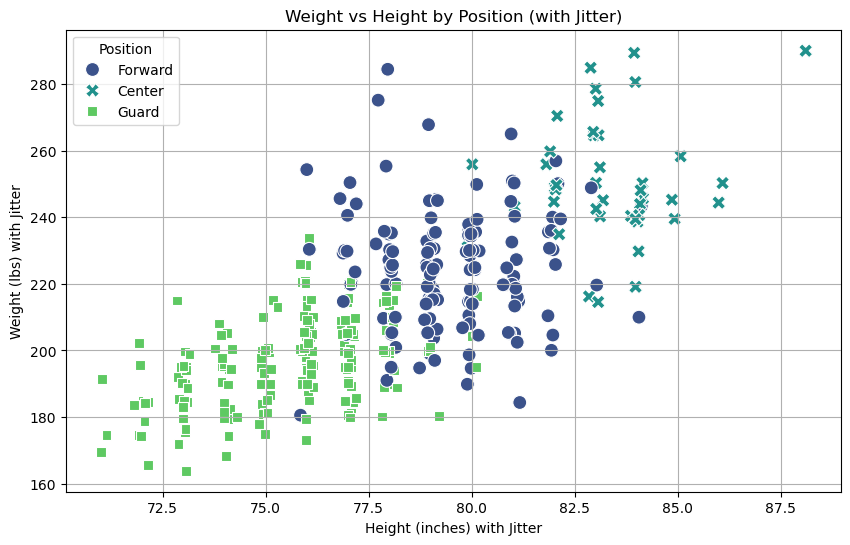

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ejemplo de DataFrame (reemplaza esto con tu DataFrame real)
# data = pd.DataFrame({
#     'weight': [180, 200, 220, 210, 195],
#     'height_inches': [72, 75, 78, 74, 73],
#     'position': ['Guard', 'Forward', 'Center', 'Guard', 'Forward']
# })

# Agregar jitter a los datos
data['height_jittered'] = data['height_inches'] + np.random.normal(0, 0.1, size=len(data))
data['weight_jittered'] = data['weight'] + np.random.normal(0, 0.5, size=len(data))

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='height_jittered', y='weight_jittered', hue='position', palette='viridis', style='position', s=100)

# Agregar títulos y etiquetas
plt.title('Weight vs Height by Position (with Jitter)')
plt.xlabel('Height (inches) with Jitter')
plt.ylabel('Weight (lbs) with Jitter')
plt.legend(title='Position')
plt.grid()

# Mostrar el gráfico
plt.show()

In [54]:
data = pd.read_csv('features_df.csv')
data = data.drop(columns=['id','height'])
X = data.drop('position', axis=1)
y = data['position']
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [38]:
#Grid search lasso
model_lasso= LogisticRegression(penalty='l1', multi_class='ovr', random_state=42, solver='liblinear')

parameter_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(model_lasso, parameter_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print(f"Best C value: {grid_search.best_params_['C']}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.2f}")
y_pred_lasso = model_lasso.fit(X_train, y_train)
model_lasso = LogisticRegression(penalty='l1', multi_class='ovr', random_state=42, solver='liblinear', C=grid_search.best_params_['C'])
model_lasso.fit(X_train, y_train)
y_pred_ridge = model_lasso.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_ridge)
classification_report_output = classification_report(y_test, y_pred_ridge)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_output)
feature_names = X.columns
classes = model_lasso.classes_
feature_names = X.columns
classes = model_lasso.classes_

coefficients_dict_lasso = {}

for i, class_name in enumerate(classes):
    class_df = pd.DataFrame({
        'Feature': feature_names,
        f'Coefficient {class_name}': model_lasso.coef_[i]
    })
    coefficients_dict_lasso[class_name] = class_df.sort_values(by=f'Coefficient {class_name}', ascending=False)

Best C value: 10
Best cross-validation accuracy: 0.85
Accuracy: 0.91
Classification Report:
              precision    recall  f1-score   support

      Center       1.00      0.88      0.93         8
     Forward       0.82      0.92      0.87        25
       Guard       0.95      0.90      0.93        42

    accuracy                           0.91        75
   macro avg       0.92      0.90      0.91        75
weighted avg       0.91      0.91      0.91        75



In [46]:
#Grid search ridge
model_ridge = LogisticRegression(penalty='l2', multi_class='ovr', random_state=42, solver='liblinear')

parameter_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(model_ridge, parameter_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print(f"Best C value: {grid_search.best_params_['C']}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.2f}")

model_ridge = LogisticRegression(penalty='l2', multi_class='ovr', random_state=42, solver='liblinear', C=grid_search.best_params_['C'])
model_ridge.fit(X_train, y_train)
y_pred_ridge = model_ridge.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_ridge)
classification_report_output = classification_report(y_test, y_pred_ridge)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_output)
feature_names = X.columns
classes = model_ridge.classes_
feature_names = X.columns
classes = model_ridge.classes_

coefficients_dict_ridge = {}

for i, class_name in enumerate(classes):
    class_df = pd.DataFrame({
        'Feature': feature_names,
        f'Coefficient {class_name}': model_ridge.coef_[i]
    })
    coefficients_dict_ridge[class_name] = class_df.sort_values(by=f'Coefficient {class_name}', ascending=False)


Best C value: 10
Best cross-validation accuracy: 0.83
Accuracy: 0.92
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.83      0.96      0.89        25
           2       0.97      0.90      0.94        42

    accuracy                           0.92        75
   macro avg       0.93      0.91      0.92        75
weighted avg       0.93      0.92      0.92        75



In [39]:
#Logistic with no penalty
model = LogisticRegression(multi_class='ovr', random_state=42, n_jobs=-1)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_output)
feature_names = X.columns
classes = model.classes_
feature_names = X.columns
classes = model.classes_

coefficients_dict = {}

for i, class_name in enumerate(classes):
    class_df = pd.DataFrame({
        'Feature': feature_names,
        f'Coefficient {class_name}': model.coef_[i]
    })
    coefficients_dict[class_name] = class_df.sort_values(by=f'Coefficient {class_name}', ascending=False)

Accuracy: 0.87
Classification Report:
              precision    recall  f1-score   support

      Center       1.00      0.50      0.67         8
     Forward       0.76      0.88      0.81        25
       Guard       0.93      0.93      0.93        42

    accuracy                           0.87        75
   macro avg       0.90      0.77      0.80        75
weighted avg       0.88      0.87      0.86        75



In [41]:
tree_model = DecisionTreeClassifier(random_state=42)
tree_params = {
    'max_depth': [2,3,5,10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
dt_search = RandomizedSearchCV(tree_model, tree_params, scoring='accuracy', random_state=42, n_jobs=-1)
dt_search.fit(X_train, y_train)
print(f"Parameters: {dt_search.best_params_}")
print("Tree Score")
print(dt_search.best_score_)

Parameters: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 2}
Tree Score
0.8766666666666666


In [42]:
forest_model = RandomForestClassifier(random_state=42)
forest_params = {
'n_estimators': [100, 200, 300],
    'max_depth': [2,3,5,10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
}
forest_search = RandomizedSearchCV(forest_model, forest_params, scoring='accuracy', random_state=42, n_jobs=-1)
forest_search.fit(X_train, y_train)
print(f"Parameters: {forest_search.best_params_}")
print("RandomForest Score")
print(forest_search.best_score_)

Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 5, 'bootstrap': False}
RandomForest Score
0.8800000000000001


In [43]:
data = pd.read_csv('features_df.csv')
data = data.drop(columns=['id', 'height'])
X = data.drop('position', axis=1)
y = data['position']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)



xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
}   

xgb_search = RandomizedSearchCV(xgb_model, xgb_params, scoring='accuracy', random_state=42, n_jobs=-1)
xgb_search.fit(X_train, y_train)


best_xgb_model = xgb_search.best_estimator_
print(f"Parameters: {xgb_search.best_params_}")

y_pred_xgb = best_xgb_model.predict(X_test)
print("XGBoost Score")
print(accuracy_score(y_test, y_pred_xgb))

d:\ANACONDA\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:27:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Parameters: {'subsample': 0.5, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
XGBoost Score
0.8533333333333334


## Endpoints

CommonPlayerInfo
 
CumeStatsPlayer (player_id y game_id), ['DATE_EST', 'VISITOR_TEAM', 'HOME_TEAM', 'GP', 'GS', 'ACTUAL_MINUTES', 'ACTUAL_SECONDS', 'FG', 'FGA', 'FG_PCT', 'FG3', 'FG3A', 'FG3_PCT', 'FT', 'FTA', 'FT_PCT', 'OFF_REB', 'DEF_REB', 'TOT_REB', 'AVG_TOT_REB', 'AST', 'PF', 'DQ', 'STL', 'TURNOVERS', 'BLK', 'PTS', 'AVG_PTS']  

CumeStatsPlayerGames (player_id) ['MATCHUP', 'GAME_ID']

Playbyplay  


playerawards (player_id) ['PERSON_ID', 'FIRST_NAME', 'LAST_NAME', 'TEAM', 'DESCRIPTION', 'ALL_NBA_TEAM_NUMBER', 'SEASON', 'MONTH', 'WEEK', 'CONFERENCE', 'TYPE', 'SUBTYPE1', 'SUBTYPE2', 'SUBTYPE3']
 
playercareerstats (player_id)  ['PLAYER_ID', 'LEAGUE_ID', 'ORGANIZATION_ID', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']


playergamelog  ['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE']


In [5]:
from nba_api.stats.endpoints import commonplayerinfo, playercareerstats

def get_player_data(player_id, endpoint):
    if endpoint == "common_player_info":
        data_dict = commonplayerinfo.CommonPlayerInfo(player_id=player_id).get_dict()
    elif endpoint == "player_career_stats":
        data_dict = playercareerstats.PlayerCareerStats(player_id=player_id).get_dict()
    else:
        return 'Invalid Endpoint'

    result_sets = data_dict['resultSets']
    data = result_sets[0]['rowSet']
    headers = result_sets[0]['headers']
    
    return pd.DataFrame(data, columns=headers)

player_info_df = get_player_data(2544, "common_player_info")
player_career_stats_df = get_player_data(2544, "player_career_stats")


# API Import

In [ ]:
def load_training_data():
    data = pd.read_csv('features_df.csv')
    data = data[ ['position', 'weight', 'games_played', 'assists', 'doubles', 'triples', 'rebounds', 'FT_percentage', 'steals', 'lost_balls', 'fouls', 'height_inches']]
    
    return data

In [ ]:
def get_player_data(player_id, endpoint):
    if endpoint == "common_player_info":
        data_dict = commonplayerinfo.CommonPlayerInfo(player_id=player_id).get_dict()
    elif endpoint == "player_career_stats":
        data_dict = playercareerstats.PlayerCareerStats(player_id=player_id).get_dict()
    else:
        return 'Invalid Endpoint'

    result_sets = data_dict['resultSets']
    data = result_sets[0]['rowSet']
    headers = result_sets[0]['headers']
    
    return pd.DataFrame(data, columns=headers)


In [61]:
def getAverageAPI(features_api, player_info_df):
    df_per_game = features_api


    avg_stats = ['FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'doubles']
    for stat in avg_stats:
        df_per_game[stat] = df_per_game[stat] / df_per_game['GP']

    
    percentage_stats = ['FG_PCT', 'FG3_PCT', 'FT_PCT']
    for stat in percentage_stats:
        df_per_game[stat] = df_per_game[stat]

    career_averages = df_per_game[avg_stats + percentage_stats].mean()

    
    total_GP = df_per_game['GP'].sum()
    career_averages['Total_GP'] = total_GP


    features_api = pd.DataFrame([career_averages])
    features_api['weight'] = player_info_df['WEIGHT'].values
    features_api['height_inches'] = player_info_df['HEIGHT'].apply(lambda x: int(x.split('-')[0]) * 12 + int(x.split('-')[1]))

    return features_api

In [105]:
def train_model(data):
    X = data.drop('position', axis=1)
    y = data['position']
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    model = LogisticRegression(penalty='l2', C=10, multi_class='ovr', random_state=42, solver='liblinear')
    model.fit(X_scaled, y)
    
    return model, scaler


In [ ]:
def pipeline(player_id):
    
    player_info_df = get_player_data(player_id, "common_player_info")
    player_career_stats_df = get_player_data(player_id, "player_career_stats")
    
    
    features_api = player_career_stats_df.drop(columns=['PLAYER_ID', 'SEASON_ID', 'LEAGUE_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'PLAYER_AGE', 'GS', 'MIN'])
    features_api['doubles'] = features_api['FGM'] - features_api['FG3M']
    features_api = features_api.drop(columns=['FGM'])
    features = getAverageAPI(features_api, player_info_df).drop(columns=['FGA', 'FG3A', 'FTM', 'FTA', 'DREB', 'OREB', 'BLK', 'FG3_PCT', 'FG_PCT', 'PTS']).rename(columns={'FG3M': 'triples', 'REB': 'rebounds', 'AST':'assists', 'STL': 'steals', 'TOV': 'lost_balls', 'PF':'fouls', 'FT_PCT':'FT_percentage', 'Total_GP':'games_played'})
    features = features.reindex(columns=['weight', 'games_played', 'assists', 'doubles', 'triples', 'rebounds', 'FT_percentage', 'steals', 'lost_balls', 'fouls', 'height_inches'])
    
    
    data = load_training_data()
    model, scaler = train_model(data)
    features_scaled = scaler.transform(features)
    result = model.predict(features_scaled)
    return result

In [127]:

import streamlit as st
def main():
    st.title("Player Position Prediction")

    # Cargar los datos de entrenamiento
    data = load_training_data()
    model, scaler = train_model(data)

    # Crear una lista de IDs de jugadores (esto puede ser dinámico, aquí uso ejemplos)
    player_ids = [2544, 200765, 203081]  # Ejemplo de IDs de jugadores, cámbialo con tus datos
    
    # Mostrar un selector para elegir un jugador
    player_id = st.selectbox("Selecciona un ID de jugador", player_ids)

    if st.button("Predecir posición"):
        # Ejecutar la función pipeline para el jugador seleccionado
        result = pipeline(player_id, model, scaler)
        st.write(f"Posición predicha para el jugador {player_id}: {result[0]}")

if __name__ == "__main__":
    main()

In [132]:
common_info = pd.read_csv('csv\common_player_info.csv')
common_info

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\pedro\AppData\Local\Temp\ipykernel_30140\2031342423.py:1: SyntaxWarning: invalid escape sequence '\c'
  common_info = pd.read_csv('csv\common_player_info.csv')


,person_id,first_name,last_name,display_first_last,display_last_comma_first,display_fi_last,player_slug,birthdate,school,country,...,playercode,from_year,to_year,dleague_flag,nba_flag,games_played_flag,draft_year,draft_round,draft_number,greatest_75_flag
0,76001,Alaa,Abdelnaby,Alaa Abdelnaby,"Abdelnaby, Alaa",A. Abdelnaby,alaa-abdelnaby,1968-06-24 00:00:00,Duke,USA,...,HISTADD_alaa_abdelnaby,1990.0,1994.0,N,Y,Y,1990,1,25,N
1,76003,Kareem,Abdul-Jabbar,Kareem Abdul-Jabbar,"Abdul-Jabbar, Kareem",K. Abdul-Jabbar,kareem-abdul-jabbar,1947-04-16 00:00:00,UCLA,USA,...,HISTADD_kareem_abdul-jabbar,1969.0,1988.0,N,Y,Y,1969,1,1,Y
2,1505,Tariq,Abdul-Wahad,Tariq Abdul-Wahad,"Abdul-Wahad, Tariq",T. Abdul-Wahad,tariq-abdul-wahad,1974-11-03 00:00:00,San Jose State,France,...,tariq_abdul-wahad,1997.0,2003.0,N,Y,Y,1997,1,11,N
3,949,Shareef,Abdur-Rahim,Shareef Abdur-Rahim,"Abdur-Rahim, Shareef",S. Abdur-Rahim,shareef-abdur-rahim,1976-12-11 00:00:00,California,USA,...,shareef_abdur-rahim,1996.0,2007.0,N,Y,Y,1996,1,3,N
4,76005,Tom,Abernethy,Tom Abernethy,"Abernethy, Tom",T. Abernethy,tom-abernethy,1954-05-06 00:00:00,Indiana,USA,...,HISTADD_tom_abernethy,1976.0,1980.0,N,Y,Y,1976,3,43,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4166,1627835,Paul,Zipser,Paul Zipser,"Zipser, Paul",P. Zipser,paul-zipser,1994-02-18 00:00:00,Bayern Munich,Germany,...,paul_zipser,2016.0,2017.0,Y,Y,Y,2016,2,48,N
4167,1627790,Ante,Zizic,Ante Zizic,"Zizic, Ante",A. Zizic,ante-zizic,1997-01-04 00:00:00,Darussafaka,Croatia,...,ante_zizic,2017.0,2019.0,Y,Y,Y,2016,1,23,N
4168,78647,Jim,Zoet,Jim Zoet,"Zoet, Jim",J. Zoet,jim-zoet,1953-12-30 00:00:00,Kent State,USA,...,HISTADD_jim_zoet,1982.0,1982.0,N,Y,Y,Undrafted,Undrafted,Undrafted,N
4169,1627826,Ivica,Zubac,Ivica Zubac,"Zubac, Ivica",I. Zubac,ivica-zubac,1997-03-18 00:00:00,Mega Basket,Croatia,...,ivica_zubac,2016.0,2023.0,Y,Y,Y,2016,2,32,N
